In [1]:
#import required packages
import pandas as pd
import numpy as np
import datetime
from time import strftime
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from itertools import chain, combinations
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from itertools import chain, combinations
%matplotlib inline

In [2]:
#mount Google Drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#read the csv file, make sure to change name if the dataset filename is different
df = pd.read_csv('/content/drive/MyDrive/dataset.csv')

In [4]:
#corrections in the dataset
#changing datatype
df['PatientId'] = df['PatientId'].astype('int64')
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay']).dt.date.astype('datetime64[ns]')
df['Alcoholism'] = df['Alcoholism'].astype('object')
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay']).dt.date.astype('datetime64[ns]')
df['SMS_Received'] = df['SMS_Received'].astype('object')
#renaming wrongly spelled words
df = df.rename(columns={'Hipertension': 'Hypertension', 'Handcap': 'Handicap', 'SMS_received': 'SMS_Received', 'No-show': 'No_Show'})
#removing unrelated details
df.drop(['PatientId', 'AppointmentID'], axis=1, inplace=True)

In [5]:
#changing datatype to object
df['Scholarship'] = df['Scholarship'].astype('object')
df['Hypertension'] = df['Hypertension'].astype('object')
df['Diabetes'] = df['Diabetes'].astype('object')
df['Handicap'] = df['Handicap'].astype('object')
#making sure that no unreasonable data is present
df = df[df.Age >= 0]

In [6]:
#displaying dataframe
df

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_Received,No_Show
0,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...
110522,F,2016-05-03,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,F,2016-05-03,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,F,2016-04-27,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,F,2016-04-27,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,No


In [7]:
# Encoding labels with label encoder to make them from 0 to m
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
le = LabelEncoder()
df['Neighbourhood'] = le.fit_transform(df['Neighbourhood'])
le = LabelEncoder()
df['No_Show'] = le.fit_transform(df['No_Show'])

In [8]:
#drop output and unrelated information from features
X = df.drop(['No_Show','ScheduledDay','AppointmentDay'], axis=1)
#separate the label
y = df['No_Show']

In [9]:
#splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [10]:
#initializing model
model = DecisionTreeClassifier(random_state=0)
#fitting model on the dataset
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [60]:
#finding contribution of each feature 
print("Feature Contribution (%):")
a  = []
lb=[]
for name, importance in zip(X.columns, np.sort(model.feature_importances_)[::-1]):
    print("{}: {:.2f}".format(name, importance*100))
    a.append(importance)
    lb.append(name)

Feature Contribution (%):
Gender: 37.37
Age: 36.86
Neighbourhood: 6.12
Scholarship: 4.98
Hypertension: 4.11
Diabetes: 3.65
Alcoholism: 3.38
Handicap: 1.87
SMS_Received: 1.65


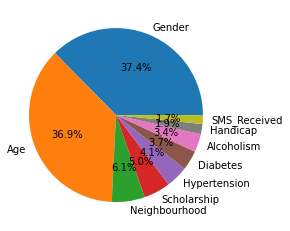

In [12]:
#visualizing feature contribution
plt.pie(a, labels = lb,autopct='%1.1f%%')
plt.show() 

In [13]:
#testing model on test sets
model.score(X_test, y_test)

0.7593354170093766

In [14]:
#changing order to get labels at the end
df = df[['Gender','Age','Neighbourhood','Scholarship','Hypertension','Diabetes','Alcoholism','Handicap','SMS_Received','No_Show']]

In [15]:
#dropping furthur features who have less contribution and due to low computational power
df = df.drop(['Handicap', 'SMS_Received', 'Alcoholism','Diabetes','Hypertension'], axis=1)

In [16]:
#testing on only 100 data enteries
df = df.head(100)
df

,Gender,Age,Neighbourhood,Scholarship,No_Show
0,0,62,39,0,0
1,1,56,39,0,0
2,0,62,45,0,0
3,0,8,54,0,0
4,0,56,39,0,0
...,...,...,...,...,...
95,1,1,8,0,0
96,1,3,8,0,0
97,0,35,8,0,0
98,0,51,8,0,0


In [17]:
#function to find powerset of propositional variables
def powerset(iterable):
    ld_1 = [{k:v} for k,v in iterable.items()]
    ld_1 = np.array(ld_1)
    s = list(ld_1)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [61]:
#function to find a knowledge base from the data
def direct_knowledge_base(df):
    keys = []
    count = [0]*1641
    labels = [0]*1641
    KB_values = [0]*1641
    c = 0
    for index, row in df.iterrows():
          feat = row[0:8]
          label = row['No_Show']
          S = list(powerset(feat))
          #print(len(S))
          for key in S:
              try:
                i=keys.index(key)
                count[i] = count[i]+1
                labels[i] = labels[i]+label
                #print(i)
              except:
                keys.append(key)
                i = len(keys)-1
                count[i] = count[i]+1
                labels[i] = labels[i]+label
    print('Done')
    for m in range(0,len(keys)):
          r = labels[m]/count[m]
          KB_values[m]=r*100
    data_for_knowledge_base = {'clauses' : keys , 'Probability(%)': KB_values}
    knowledge_base = pd.DataFrame(data_for_knowledge_base)
    return knowledge_base

In [62]:
KB = direct_knowledge_base(df)

Done


In [63]:
KB

,clauses,Probability(%)
0,(),19.000000
1,"({'Gender': 0},)",19.354839
2,"({'Age': 62},)",0.000000
3,"({'Neighbourhood': 39},)",0.000000
4,"({'Scholarship': 0},)",16.853933
...,...,...
1636,"({'Gender': 0}, {'Age': 51}, {'Neighbourhood':...",0.000000
1637,"({'Gender': 0}, {'Age': 51}, {'Neighbourhood':...",0.000000
1638,"({'Gender': 0}, {'Age': 51}, {'Scholarship': 0...",0.000000
1639,"({'Age': 51}, {'Neighbourhood': 8}, {'Scholars...",0.000000


In [38]:
#Saving knowledge base to excel file
knowledge_base.to_excel('knowledge_base.xlsx')